In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint
from functools import reduce

In [2]:
def load_data(filename: str) -> dict[str, pd.DataFrame]:
    data = {}
    with pd.HDFStore(filename) as store:
        for k in store.keys():
            data[k] = store.get(k)
    return data

def transform_data(data: dict[str, pd.DataFrame]) -> tuple[
        np.ndarray, # points
        list[tuple[int, int, int]],
        np.ndarray, # angles
        np.ndarray  # corrections
    ]:
    i_list = list(data['/measurements'].get('i').values.flatten())
    j_list = list(data['/measurements'].get('j').values.flatten())
    k_list = list(data['/measurements'].get('k').values.flatten())
    indices = [(i-1, j-1, k-1) for i, j, k in zip(i_list, j_list, k_list)]
    angles = np.array(data['/measurements'].get('theta').values.flatten())
    points = np.array([data['/r'].loc[[k]].values.flatten() for k in data['/r'].index])
    corrections = np.array([data['/dr'].loc[[k]].values.flatten() for k in data['/dr'].index])
    return (points, indices, angles, corrections)

In [3]:
data1 = load_data('localization_data_1.hdf')
data2 = load_data('localization_data_2.hdf')
print(reduce(lambda acc, s: f'{acc}\n{s}',
             map(lambda x: f"{'-'*40}<({x[0][1:]})\n{x[1]}\n{'-'*30}\n",
                 data2.items())))

----------------------------------------<(dr)
             dx        dy
point                    
1     -0.012469  0.000194
2      0.013173 -0.104997
3     -0.019315  0.070825
4     -0.123992 -0.006053
5      0.070039  0.010909
6      0.072564  0.029123
------------------------------

----------------------------------------<(measurements)
             i  j  k     theta
measurement                   
1            1  2  5  1.570800
2            3  2  5  1.570800
3            5  4  3  0.523599
4            3  2  6  1.047200
------------------------------

----------------------------------------<(r)
              x         y
point                    
1      1.264126  0.085318
2      0.894840  0.957372
3     -0.410136  0.925109
4     -0.722170 -0.228867
5     -0.696117 -0.762520
6      0.417324 -1.136625
------------------------------



In this task we are solving a common constrained optimization problem: for given $r_i, \theta_{ijk}$ find
$$ \min_{\tilde{r}_i}\left\| \tilde{r}_i - r_i \right\|_2 $$
for all $i$ such that
$$ \theta_{ijk} = \frac{(r_j - r_i) \cdot (r_j - r_i)}{\left\| r_k - r_i \right\|_2 \cdot \left\| r_j - r_i \right\|_2} $$
for all $(i, j, k)$ given.

In [4]:
def constraint_function_inner(r: jnp.ndarray, indices: list[tuple[int, int, int]]):
    return np.array([jnp.arccos(jnp.divide(jnp.dot(r[k] - r[i], r[j] - r[i]),
                                             jnp.multiply(jnp.linalg.norm(r[k] - r[i]),
                                                          jnp.linalg.norm(r[j] - r[i])))) for i, j, k in indices])

In [9]:
def process_data(data: dict['str', pd.DataFrame]):
    points, indices, angles, corrections = transform_data(data)
    n = len(points)
    d = 2
    constraint = NonlinearConstraint(fun=lambda r: constraint_function_inner(r.reshape([n, d]), indices),
                                    lb=angles,
                                    ub=angles)
    return (minimize(fun=lambda r: jnp.linalg.norm(r - points.flatten(), ord=2),
                    x0=np.random.uniform(size=n * d),
                    method='trust-constr',
                    constraints=constraint), points, corrections)

In [67]:
def process_data(data: dict['str', pd.DataFrame]):
    points, indices, angles, corrections = transform_data(data)
    n = len(points)
    d = 2
    constraint = NonlinearConstraint(fun=lambda r: constraint_function_inner(r.reshape([n, d]), indices),
                                    lb=angles,
                                    ub=angles)
    return (minimize(fun=lambda r: np.linalg.norm(r - points.flatten(), ord=2),
                    x0=np.random.uniform(size=n * d),
                    method='trust-constr',
                    constraints=constraint), points, corrections)

### Dataset #1

In [68]:
result, points, true_dr = process_data(data1)
dr = result['x'].reshape(points.shape) - points
print(result)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 0.08002599341615771
                x: [-1.037e+00  2.463e-03  3.828e-02  9.568e-01  9.992e-01
                     4.074e-02]
              nit: 37
             nfev: 385
             njev: 55
             nhev: 0
         cg_niter: 50
     cg_stop_cond: 2
             grad: [-4.685e-01  3.078e-02  4.784e-01 -5.398e-01 -9.942e-03
                     5.091e-01]
  lagrangian_grad: [ 6.411e-04  6.814e-04  2.052e-04 -2.115e-04  9.037e-05
                     1.354e-04]
           constr: [array([ 7.069e-01], dtype=float32)]
              jac: [array([[ 4.521e-01, -2.900e-02, -4.608e-01,  5.200e-01,
                            9.667e-03, -4.905e-01]])]
      constr_nfev: [385]
      constr_njev: [0]
      constr_nhev: [0]
                v: [array([ 1.038e+00])]
           method: equality_constrained_sqp
       optimality: 0.0006813812496410596
 constr_violation: 

/home/huldre/Data/Documents/Numericals/.venv/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


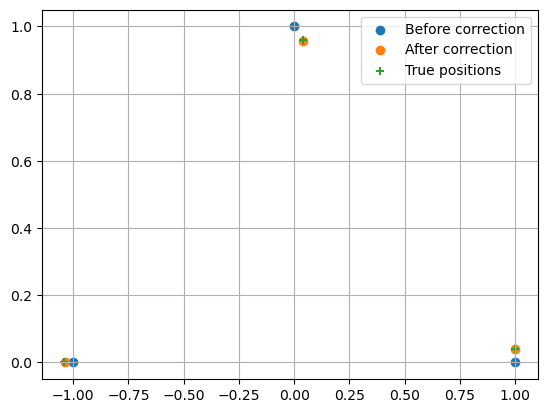

In [69]:
true_points = points + true_dr
computed_points = result['x'].reshape(points.shape)
plt.scatter(points[:,0], points[:,1], label='Before correction')
plt.scatter(computed_points[:,0], computed_points[:,1], label='After correction')
plt.scatter(true_points[:,0], true_points[:,1], label='True positions', marker='+')
plt.grid(True)
plt.legend()
plt.show()

### Dataset #2

In [84]:
result, points, true_dr = process_data(data2)
dr = result['x'].reshape(points.shape) - points
print(result)

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 0.20674915056096732
                x: [ 1.237e+00  8.478e-02  9.045e-01  8.513e-01 -4.258e-01
                     1.007e+00 -8.235e-01 -2.725e-01 -6.291e-01 -7.239e-01
                     4.851e-01 -1.107e+00]
              nit: 41
             nfev: 741
             njev: 57
             nhev: 0
         cg_niter: 80
     cg_stop_cond: 2
             grad: [-1.325e-01 -2.580e-03  4.688e-02 -5.132e-01 -7.574e-02
                     3.985e-01 -4.902e-01 -2.112e-01  3.241e-01  1.869e-01
                     3.279e-01  1.415e-01]
  lagrangian_grad: [ 7.996e-05 -3.260e-05  2.216e-04 -4.080e-05 -1.986e-04
                    -9.140e-05 -1.839e-05  1.432e-04 -2.756e-05  2.569e-04
                    -1.177e-04  1.522e-04]
           constr: [array([ 1.571e+00,  1.571e+00,  5.236e-01,  1.047e+00],
                         dtype=float32)]
              jac: [array([

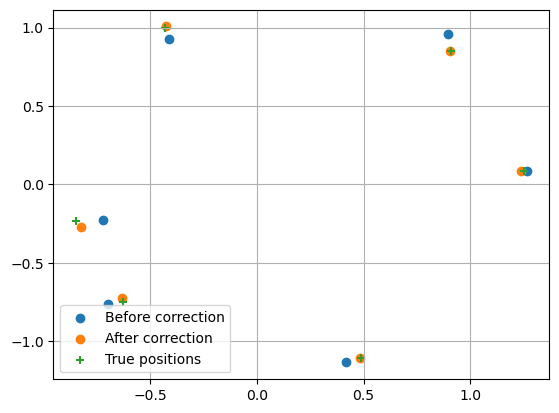

In [85]:
true_points = points + true_dr
computed_points = result['x'].reshape(points.shape)
plt.scatter(points[:,0], points[:,1], label='Before correction')
plt.scatter(computed_points[:,0], computed_points[:,1], label='After correction')
plt.scatter(true_points[:,0], true_points[:,1], label='True positions', marker='+')
plt.grid(True)
plt.legend()
plt.show()